In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine('sqlite:///hawaii.sqlite')

In [7]:
# reflect an existing database into a new model
Base = automap_base()

Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
Base.classes.keys()

['measurement', 'station']


# Exploratory Climate Analysis

One year from the last recorded date was 2017-06-18


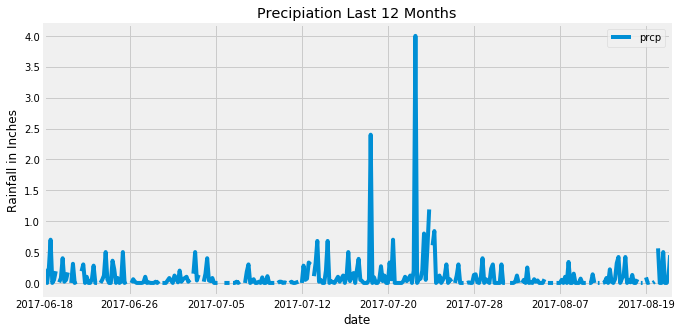

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12 = session.query (Measurement.date, Measurement.prcp).order_by(Measurement.date)[-365:]

#convert to data frame
last12_df = pd.DataFrame(last12)

#set index to date
last12_df.set_index('date')

# Calculate the date 1 year ago from the last data point in the database
year_ago_date = session.query((Measurement.date)).order_by(Measurement.date.desc()).limit(365).all()
yad = year_ago_date[len(year_ago_date)-1][0]


last12_df.plot.line(x='date',legend = True, figsize = (10,5), title = "Precipiation Last 12 Months")
plt.ylabel("Rainfall in Inches")

print(f"One year from the last recorded date was {yad}")

In [22]:
last12

[('2017-06-18', 0.25),
 ('2017-06-18', 0.18),
 ('2017-06-18', 0.0),
 ('2017-06-18', 0.24),
 ('2017-06-18', 0.7),
 ('2017-06-19', 0.0),
 ('2017-06-19', 0.05),
 ('2017-06-19', 0.19),
 ('2017-06-19', None),
 ('2017-06-19', 0.01),
 ('2017-06-19', 0.08),
 ('2017-06-19', 0.4),
 ('2017-06-20', 0.02),
 ('2017-06-20', 0.05),
 ('2017-06-20', 0.17),
 ('2017-06-20', None),
 ('2017-06-20', 0.0),
 ('2017-06-20', 0.31),
 ('2017-06-21', 0.0),
 ('2017-06-21', 0.02),
 ('2017-06-21', None),
 ('2017-06-21', None),
 ('2017-06-21', 0.19),
 ('2017-06-21', 0.3),
 ('2017-06-22', 0.0),
 ('2017-06-22', 0.1),
 ('2017-06-22', 0.0),
 ('2017-06-22', 0.0),
 ('2017-06-22', 0.06),
 ('2017-06-22', 0.28),
 ('2017-06-23', 0.0),
 ('2017-06-23', 0.0),
 ('2017-06-23', None),
 ('2017-06-23', 0.0),
 ('2017-06-23', 0.05),
 ('2017-06-23', 0.12),
 ('2017-06-23', 0.5),
 ('2017-06-24', 0.06),
 ('2017-06-24', 0.0),
 ('2017-06-24', 0.0),
 ('2017-06-24', 0.36),
 ('2017-06-24', 0.22),
 ('2017-06-25', 0.0),
 ('2017-06-25', 0.08),
 ('201

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last12_df.describe()

,prcp
count,329.000000
mean,0.107112
std,0.297826
min,0.000000
25%,0.000000
50%,0.020000
75%,0.100000
max,4.000000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations reporting")

There are 9 stations reporting


In [73]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

active_df = pd.DataFrame(active_stations, columns = ['station','prcp'])
active_df = active_df.set_index('station')

top_observer = session.query(Measurement.station, 
                             func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).first()

top_ob =top_observer[0]


print(active_df)
print(f"The station with the most reports was station {top_ob}")

             prcp
station          
USC00519281  2772
USC00513117  2696
USC00519397  2685
USC00519523  2572
USC00516128  2484
USC00514830  1937
USC00511918  1932
USC00517948   683
USC00518838   342
The station with the most reports was station USC00519281


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12_temps = session.query (Measurement.date, Measurement.tobs).order_by(Measurement.date)[-364:]

temps_df = pd.DataFrame(last12_temps)

active_station_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).order_by(func.count(Measurement.tobs).desc()).all()

top_observer_temp = session.query(Measurement.station, 
                             func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).first()

top_observer_temp =top_observer_temp[0]


print(f"The station with the most reports was station {top_observer_temp}")

The station with the most reports was station USC00519281


Text(0, 0.5, 'Frequency')

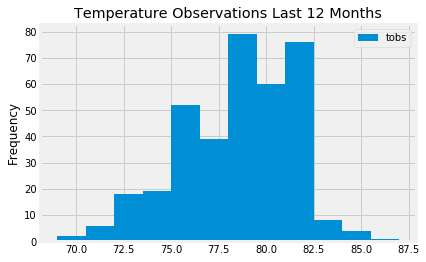

In [17]:
temps_df.plot.hist(x = 'date',bins = 12 , title = "Temperature Observations Last 12 Months")
plt.ylabel("Frequency")

![precipitation](Images/station-histogram.png)

In [69]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
#     """TMIN, TAVG, and TMAX for a list of dates.
    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps= def calc_temps(start_date, end_date):
             calc_temps('2012-02-28', '2012-03-05')
calc_temps

SyntaxError: invalid syntax (<ipython-input-20-fac19a5fa199>, line 3)

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
